# Welcome to my current analysis of Airbnbs in Florence

In [2]:
import pandas as pd
import numpy as np
import statistics as st
import matplotlib as plt
import scipy
from scipy import stats
from scipy.stats import describe
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import folium
import csv
from IPython.display import display, HTML
from pathlib import Path 
import os
from datetime import date, time, datetime
from dateutil import tz #for dealing with timezone

### During preprocessing of the CSV file from Inside Airbnb that I downloaded on 1/27/2022 I reduced the total number of listings by three quarters to make it faster to analyze for now. 
<p> The total listings count in the below analysis is 2500, originally it was a little over 10k. <p>


In [4]:
df = pd.read_csv("../choropleth/final_joined_census_ia_var.csv")
#print(df.head())
# print(df.size)
#rename confusing variable names
df.rename({'host_total_listings_count': 'listings_count_excluding_florence', 'number_of_reviews_ltm': 'total_reviews_last_12_months','number_of_reviews_l30d': 'total_reviews_last_30_days', 'calculated_host_listings_count': 'listings_count_florence','reviews_per_month': 'lifetime_review_monthly_rate','days_rented': 'est_days_rented', 'rounded_revenue': 'est_revenue_year', 'neighbourhood_cleansed': 'neighborhood', 'has_liscense':'has_license'}, inplace=True, errors='raise', axis='columns')
print(df.head())


   Unnamed: 0        id                            listing_url last_scraped  \
0           0  19540062  https://www.airbnb.com/rooms/19540062   2021/12/17   
1           1    998704    https://www.airbnb.com/rooms/998704   2021/12/17   
2           2   3441668   https://www.airbnb.com/rooms/3441668   2021/12/17   
3           3  11816924  https://www.airbnb.com/rooms/11816924   2021/12/17   
4           4  16684187  https://www.airbnb.com/rooms/16684187   2021/12/17   

                                    name    host_id  host_name  host_since  \
0                       Flat with a view  137252010     Giulia  2017/06/27   
1        Bright comfortable " mini-loft"    5488837    Antonio  2013/03/16   
2         Cozy room for young travellers   17343973    Susanna  2014/06/27   
3  Comfortable room in Florence downtown    8947203  Salvatore  2013/09/20   
4                         Stibbert relax  110438072       Luca  2017/01/08   

              host_location  listings_count_excluding_fl

In [6]:
quant_labels = ['listings_count_excluding_florence','listings_count_florence', 'accommodates', 'bedrooms', 'total_reviews_last_12_months', 'total_reviews_last_30_days', 'lifetime_review_monthly_rate', 'est_days_rented', 'est_revenue_year', 'is_hotel', 'is_entire', 'many_listings', 'only_1_listing', 'only_2_listings', 'host_florence', 'has_license', 'is_instant_bookable']
df_quant = df.loc[:, quant_labels]
qual_labels = ['id', 'listing_url', 'name', 'host_id', 'host_name', 'host_location', 'neighborhood', 'room_type', 'license', 'instant_bookable']
df_qual = df.loc[:, qual_labels].astype("category")
continuous_quant_labels = ['host_since', 'latitude', 'longitude', 'price']
df_continuous = df.loc[:, continuous_quant_labels]

In [7]:
print(df.head())

   Unnamed: 0        id                            listing_url last_scraped  \
0           0  19540062  https://www.airbnb.com/rooms/19540062   2021/12/17   
1           1    998704    https://www.airbnb.com/rooms/998704   2021/12/17   
2           2   3441668   https://www.airbnb.com/rooms/3441668   2021/12/17   
3           3  11816924  https://www.airbnb.com/rooms/11816924   2021/12/17   
4           4  16684187  https://www.airbnb.com/rooms/16684187   2021/12/17   

                                    name    host_id  host_name  host_since  \
0                       Flat with a view  137252010     Giulia  2017/06/27   
1        Bright comfortable " mini-loft"    5488837    Antonio  2013/03/16   
2         Cozy room for young travellers   17343973    Susanna  2014/06/27   
3  Comfortable room in Florence downtown    8947203  Salvatore  2013/09/20   
4                         Stibbert relax  110438072       Luca  2017/01/08   

              host_location  listings_count_excluding_fl

<p>I also dropped variables that weren't needed now these include:<p>
["scrape_id","last_scraped", "bathrooms_text","host_verifications", "host_neighbourhood","property_type", "amenities", "host_verifications", "neighbourhood", "host_listings_count", "picture_url","host_url", "description", "neighborhood_overview", "host_about", "host_response_time", "host_response_rate", 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic', 'host_identity_verified', 'calendar_updated', 'has_availability', 'calendar_last_scraped', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'neighbourhood_group_cleansed', 'beds', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'bathrooms', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms']

## Summary Statistics of all quantitative variables below 

I created 10 new variables, found at the end of the list below, most of which are binary versions of the categorical data (except for days_rented and rounded_revenue).

**days_rented** was calculated by dividing the **number of reviews a year** by the **average rate** (according to Airbnb) that a guest will give a review **(70%)** then multiplied by the **average tourist stay** in Florence according to Statista **(2.6 days)**
<p> days_rented = (int(row[20])/.7)*2.6 <p>

**rounded_revenue** was calculated by multiplying the **listing's price** by the **days_rented** variable to get the approximate yearly revenue per listing.
<p> rounded_revenue = days_rented * price <p>

In [11]:
df_quant.describe().transpose().to_csv("../choropleth/summary_stats_quant.csv")

### Summary Statistics of all qualitative variables below

In [10]:
df_qual.describe().transpose().to_csv("../choropleth/summary_stats_qual.csv")


Variables included in the final csv that I prepared include: 
['', 'id', 'listing_url', 'name', 'host_id', 'host_name', 'host_since', 'host_location', 'host_total_listings_count', 'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type', 'accommodates', 'bedrooms', 'price', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'license', 'instant_bookable', 'calculated_host_listings_count', 'reviews_per_month', 'days_rented', 'rounded_revenue', 'is_hotel', 'is_entire', 'many_listings', 'only_1_listing', 'only_2_listings', 'host_florence', 'has_liscense', 'is_instant_bookable'  ]

## SO what can we know about the Airbnb's with the data we have? Following are a few questions that we can answer.... 

### Hosted or Unhosted? If the listing is "entire" it means it isn't being shared and so is unhosted. 

In [ ]:
tab = (pd.crosstab(index=df['is_entire'], columns='frequency')) 
#print(tab)
tab/tab.sum()

col_0,frequency
is_entire,
0,0.221511
1,0.778489


### Is the host located in Florence? 

In [ ]:
tab = (pd.crosstab(index=df['host_florence'], columns='frequency')) 
#print(tab)
tab/tab.sum()

col_0,frequency
host_florence,
0,0.201919
1,0.798081


### Does the host have a liscense listed on their Airbnb Listing?

In [ ]:
tab = (pd.crosstab(index=df['has_liscense'], columns='frequency')) 
#print(tab)
tab/tab.sum()

col_0,frequency
has_liscense,
0,0.947221
1,0.052779


### Does the host have multiple listings, more than 2? 

In [ ]:
tab = (pd.crosstab(index=df['many_listings'], columns='frequency')) 
#print(tab)
tab/tab.sum()

col_0,frequency
many_listings,
0,0.510996
1,0.489004


## Histogram and Scatter Plot Matrix

### Histogram and Scatter Plot Matrix for 10 select variables that help us understand the type of Airbnb Activity and Listings in Florence in 2022

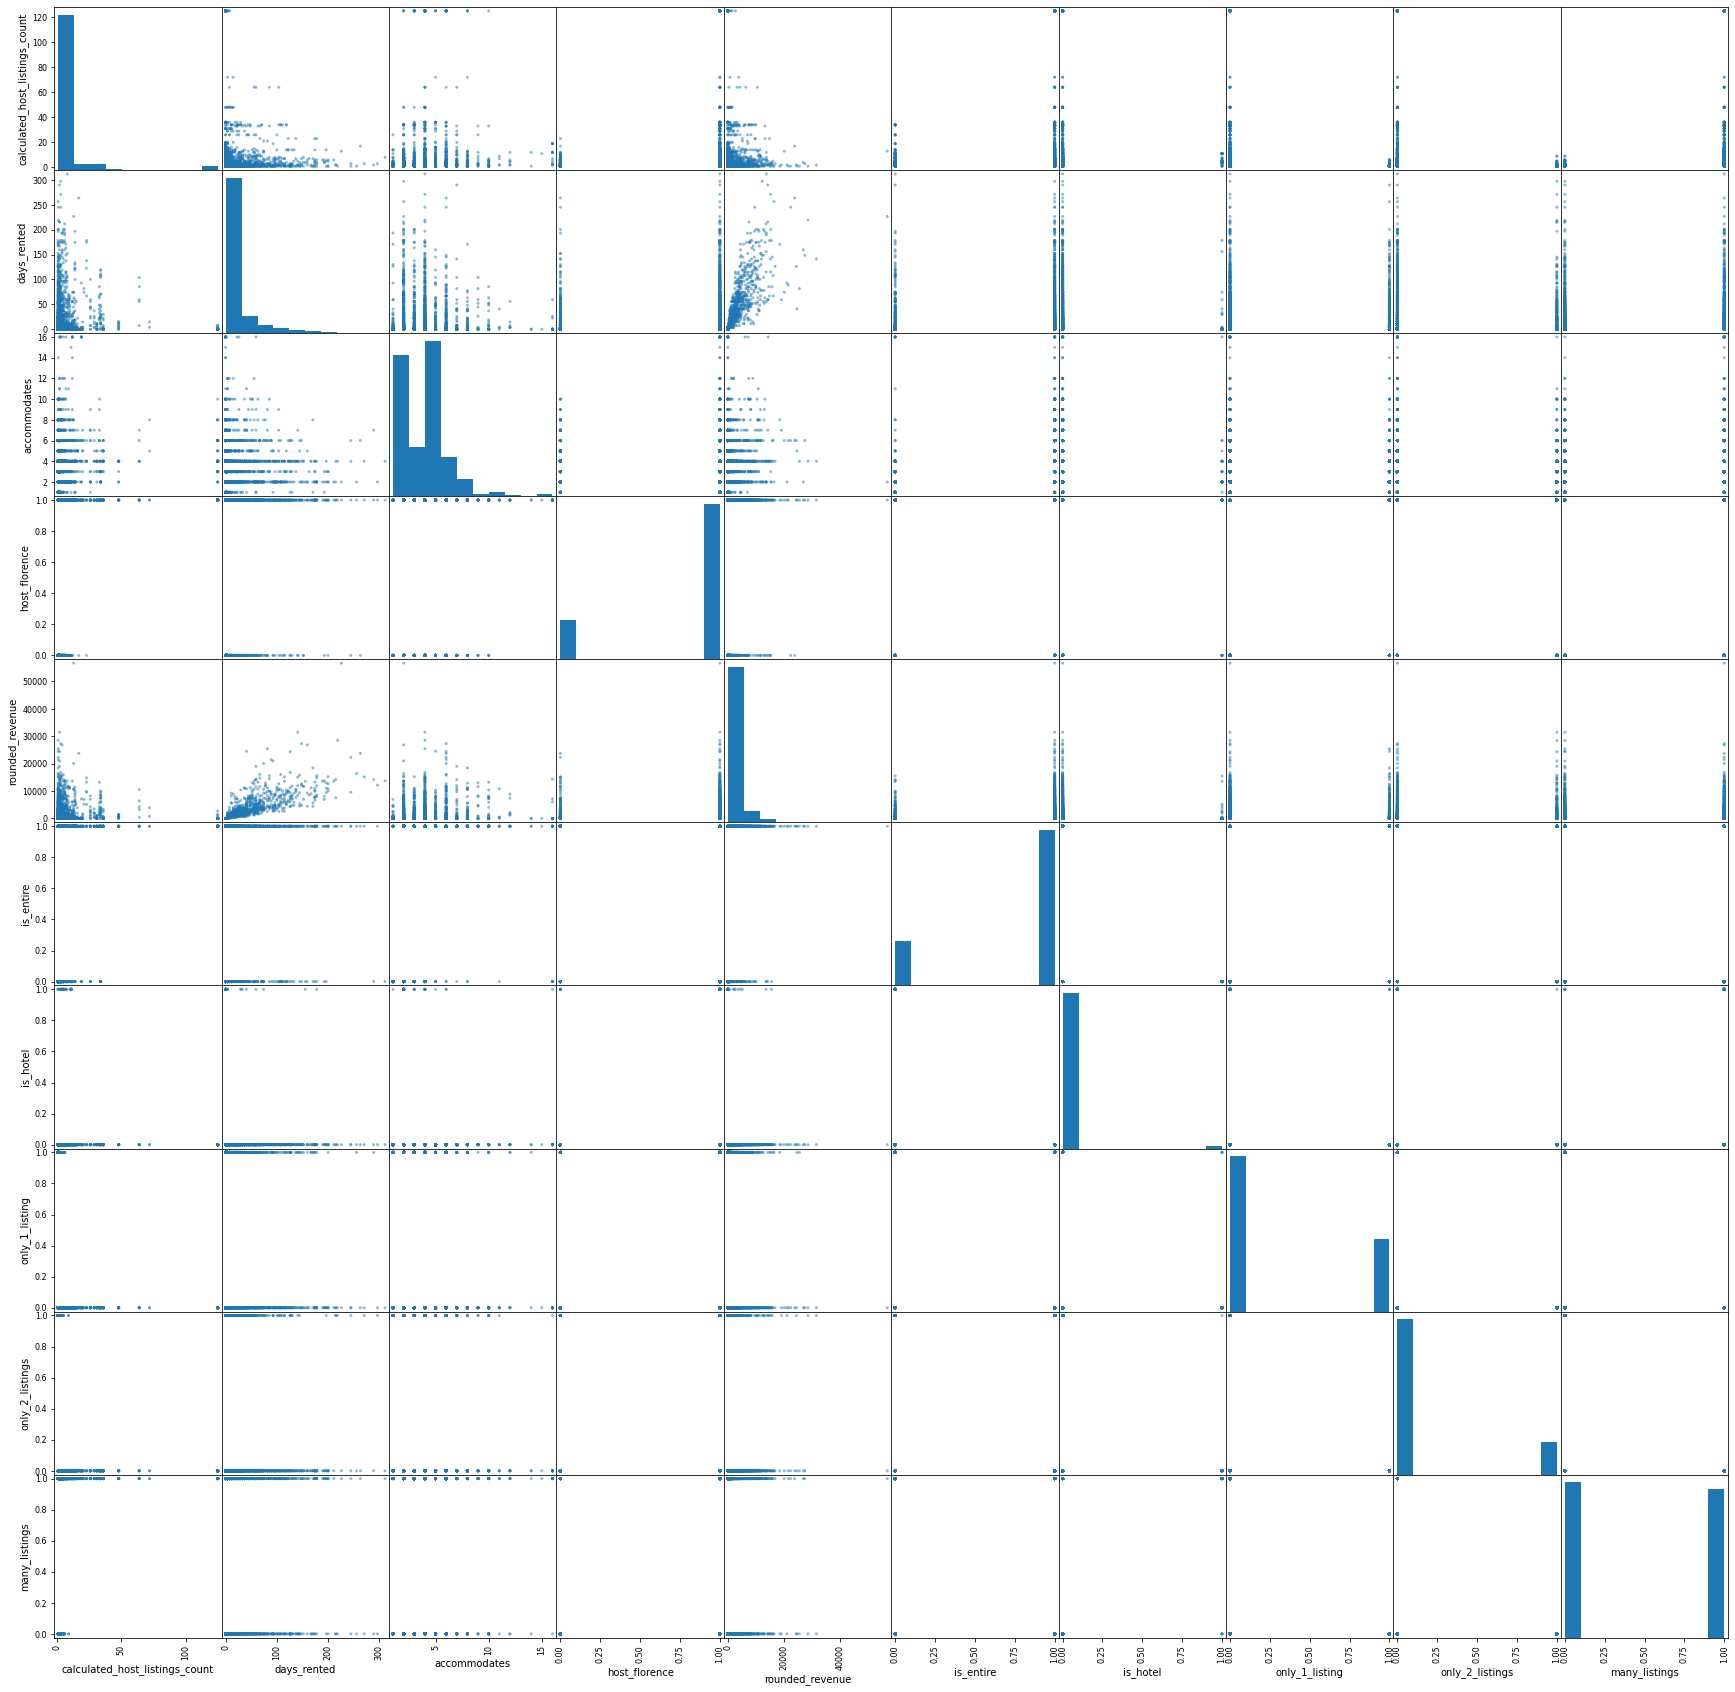

In [ ]:
labels_matrix_plot = ['calculated_host_listings_count', 'days_rented', 'accommodates', 'host_florence', 'rounded_revenue', 'is_entire', 'is_hotel', 'only_1_listing', 'only_2_listings', 'many_listings']
data = df.loc[:, labels_matrix_plot]
pd.plotting.scatter_matrix(data, diagonal="hist", figsize=(30, 30))  #alpha=0.2 #hist kde
#plt.pyplot.tight_layout()
plt.pyplot.show()

### Histogram and Scatter Plot Matrix Highligting Two Important Variables: Approx days the listing is used in a year, and approx total yearly revenue on that listing

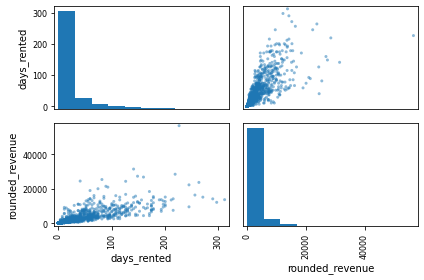

In [ ]:
data = df.loc[:, 'days_rented': 'rounded_revenue' ]
pd.plotting.scatter_matrix(data, diagonal="hist")  #alpha=0.2 #hist kde
plt.pyplot.tight_layout()
plt.pyplot.show()

## Pivot Tables

### By Neighborhood, the average total listings count for a host by room type

In [ ]:
data = df
pivot_discrete_neighbourhood = pd.pivot_table(data=data, index=["neighbourhood_cleansed"],columns=["room_type"], values='host_total_listings_count', aggfunc='mean')
print(pivot_discrete_neighbourhood)

room_type               Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_cleansed                                                        
Campo di Marte                 4.047337    5.000000      2.478723          NaN
Centro Storico                14.746762    7.891892      5.455150     1.666667
Gavinana Galluzzo              4.265625    4.333333      2.400000     1.000000
Isolotto Legnaia               2.563380         NaN      2.387097          NaN
Rifredi                        2.989899    3.000000      2.375000     4.000000


### By Neighborhood, the average yearly revenue for a listing by room type

In [ ]:
data = df
pivot_discrete_neighbourhood = pd.pivot_table(data=data, index=["neighbourhood_cleansed"],columns=["room_type"], values='rounded_revenue', aggfunc='mean')
print(pivot_discrete_neighbourhood)

room_type               Entire home/apt   Hotel room  Private room  \
neighbourhood_cleansed                                               
Campo di Marte               965.626391   561.600000    264.069681   
Centro Storico              2049.333122  1188.872703   1073.736977   
Gavinana Galluzzo           2013.897187  1212.096667     57.624571   
Isolotto Legnaia             605.062254          NaN     77.760323   
Rifredi                      988.825455     0.000000    182.000250   

room_type               Shared room  
neighbourhood_cleansed               
Campo di Marte                  NaN  
Centro Storico                  0.0  
Gavinana Galluzzo               0.0  
Isolotto Legnaia                NaN  
Rifredi                         0.0  


### By Neighborhood, the average number of people a listing can accommodate by room type

In [ ]:
data = df
pivot_discrete_neighbourhood = pd.pivot_table(data=data, index=["neighbourhood_cleansed"],columns=["room_type"], values='accommodates', aggfunc='mean')
print(pivot_discrete_neighbourhood)

room_type               Entire home/apt  Hotel room  Private room  Shared room
neighbourhood_cleansed                                                        
Campo di Marte                 4.071006         2.4      1.968085          NaN
Centro Storico                 4.176813         3.0      2.408638     1.333333
Gavinana Galluzzo              4.343750         3.0      2.485714     3.000000
Isolotto Legnaia               4.084507         NaN      2.290323          NaN
Rifredi                        4.060606         2.0      2.125000     2.000000


### By Neighborhood, the average total listings count for a host based on whether the host is located in Florence or not

In [ ]:
data = df
pivot_discrete_neighbourhood = pd.pivot_table(data=data, index=["neighbourhood_cleansed"],columns=["host_florence"], values='host_total_listings_count', aggfunc='mean')
print(pivot_discrete_neighbourhood)

host_florence                  0          1
neighbourhood_cleansed                     
Campo di Marte          2.102564   3.755459
Centro Storico          6.856410  14.738462
Gavinana Galluzzo       2.625000   3.898734
Isolotto Legnaia        1.944444   2.630952
Rifredi                 3.117647   2.743119


### By Neighborhood, the summed yearly revenue for all hosts based on whether they are based in Florence or not

In [ ]:
data = df
pivot_discrete_neighbourhood = pd.pivot_table(data=data, index=["neighbourhood_cleansed"],columns=["host_florence"], values='rounded_revenue', aggfunc='sum')
print(pivot_discrete_neighbourhood)

host_florence                   0           1
neighbourhood_cleansed                       
Campo di Marte           13597.99   177223.42
Centro Storico          548704.02  2982649.44
Gavinana Galluzzo         9787.15   124755.42
Isolotto Legnaia          7447.14    37922.85
Rifredi                  35014.57    70159.16


### By whether the host is based in Florence or not, the summed yearly revenue for all hosts based on whether they have more than 2 listings

In [ ]:
data = df
pivot_discrete_neighbourhood = pd.pivot_table(data=data, index=["host_florence"],columns=["many_listings"], values='rounded_revenue', aggfunc='sum')
print(pivot_discrete_neighbourhood)

many_listings           0           1
host_florence                        
0               288221.11   326329.76
1              1427247.66  1965462.63


## The end, for now

To do: 
- choropleth map versions of data analysis
- find r squared intercept value for scatter plots to see if correlated days rented and revenue 
- chisquare to see if commercial correlates to revenue and or center and having more rentals, renting for more 90 days
- from mcgill survey of nyc create new inequality analysis
- check out who's used days_rented formula how to make it more geo granular or better (notes in green notebook from fed)
- create new variables from list in green notebook
    - do qgis renaming for census tract and to figure out how many people live in a certain area (check skew of location with the sant ambrogio spot) to create those variables
- create dictionary hosts so can have top 10 hosts by revenue and listings and click on one listing and see all other listings by same host
- create dictionary neighborhood d2 center buffer ring so can have all these variables by zone, and can display that in tool

In [ ]:
#chloropleth version of these contextual histograms 